In [3]:
# Saab transformationv 2021.04.12
# modified from https://github.com/ChengyaoWang/PixelHop-_c-wSaab/blob/master/saab.py

import numpy as np
import numba
# from sklearn.decomposition import PCA, IncrementalPCA


@numba.jit(nopython = True, parallel = True)
def pca_cal(X: np.ndarray):
    cov = X.transpose() @ X
    eva, eve = np.linalg.eigh(cov)
    inds = eva.argsort()[::-1]
    eva = eva[inds]
    kernels = eve.transpose()[inds]
    return kernels, eva / (X.shape[0] - 1)

@numba.jit(forceobj = True, parallel = True)
def remove_mean(X: np.ndarray, feature_mean: np.ndarray):
    return X - feature_mean

@numba.jit(nopython = True, parallel = True)
def feat_transform(X: np.ndarray, kernel: np.ndarray):
    return X @ kernel.transpose()


class Saab():
    def __init__(self, num_kernels=-1, needBias=True, bias=0):
        self.num_kernels = num_kernels 
        self.needBias = needBias
        self.Bias_previous = bias # bias calculated from previous
        self.Bias_current = [] # bias for the current Hop
        self.Kernels = []
        self.Mean0 = [] # feature mean of AC
        self.Energy = [] # kernel energy list
        self.trained = False

    def fit(self, X): 
        assert (len(X.shape) == 2), "Input must be a 2D array!"
        X = X.astype('float32')
        
        # add bias from the previous Hop
        if self.needBias == True:
            X += self.Bias_previous
            
        # remove DC, get AC components
        dc = np.mean(X, axis = 1, keepdims = True)
        X = remove_mean(X, dc)
        
        # calcualte bias at the current Hop
        self.Bias_current = np.max(np.linalg.norm(X, axis=1))
        
        # remove feature mean --> self.Mean0
        self.Mean0 = np.mean(X, axis = 0, keepdims = True)
        X = remove_mean(X, self.Mean0)

        if self.num_kernels == -1:
            self.num_kernels = X.shape[-1]
        
        # Rewritten PCA Using Numpy
        kernels, eva = pca_cal(X)
        
        # Concatenate with DC kernel
        dc_kernel = 1 / np.sqrt(X.shape[-1]) * np.ones((1, X.shape[-1]))# / np.sqrt(largest_ev)
        kernels = np.concatenate((dc_kernel, kernels[:-1]), axis = 0)
        
        # Concatenate with DC energy
        largest_ev = np.var(dc * np.sqrt(X.shape[-1]))  
        energy = np.concatenate((np.array([largest_ev]), eva[:-1]), axis = 0)
        energy = energy / np.sum(energy)
        
        # store
        self.Kernels, self.Energy = kernels.astype('float32'), energy
        self.trained = True


    def transform(self, X):
        assert (self.trained == True), "Must call fit first!"
        X = X.astype('float32')
        
        # add bias from the previous Hop
        if self.needBias == True:
            X += self.Bias_previous
            
        # remove feature mean of AC
        X = remove_mean(X, self.Mean0)
        
        # convolve with DC and AC filters
        X = feat_transform(X, self.Kernels)
        
        return X

In [4]:
from sklearn import datasets
import warnings
warnings.filterwarnings("ignore")

print(" > This is a test example: ")
digits = datasets.load_digits()
data = digits.images.reshape((len(digits.images), 8, 8, 1))
print(" input feature shape: %s"%str(data.shape))

 > This is a test example: 
 input feature shape: (1797, 8, 8, 1)


In [6]:
# read test_lungs.jpg
import cv2

img = cv2.imread('test_lungs.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (8, 8))
img = img.reshape((1, 8, 8, 1))
print(" input feature shape: %s"%str(img.shape))

 input feature shape: (1, 8, 8, 1)


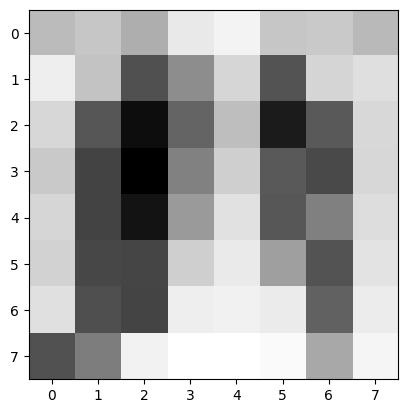

In [7]:
# show img
import matplotlib.pyplot as plt

plt.imshow(img.reshape(8, 8), cmap='gray')
plt.show()

In [ ]:
# add img to X in the first row
X = data.copy()
X = X.reshape(X.shape[0], -1)[0:100]
X = np.concatenate((img.reshape(1, -1), X), axis=0)
print(X)

In [12]:
saab = Saab(num_kernels=-1, needBias=True, bias=0)
saab.fit(X)

Xt = saab.transform(X)
print(" output feature shape: %s"%str(Xt.shape))
# print(Xt)
# print Xt image with imgshow
# print in matrix 8,8
print(" > Gambar sebelum Saab Transform:")
print(X[0].reshape(8,8))
print("\n > Gambar setelah Saab Transform:")
print(Xt[0].reshape(8,8))

 output feature shape: (101, 64)
 > Gambar sebelum Saab Transform:
[[172. 182. 160. 213. 222. 182. 184. 170.]
 [217. 179.  76. 131. 196.  79. 195. 204.]
 [197.  81.  16.  94. 174.  29.  84. 198.]
 [184.  64.   4. 120. 190.  85.  71. 197.]
 [196.  64.  21. 142. 206.  82. 119. 202.]
 [192.  68.  66. 190. 214. 147.  79. 208.]
 [205.  75.  65. 217. 220. 215.  91. 216.]
 [ 77. 116. 221. 233. 233. 228. 155. 224.]]

 > Gambar setelah Saab Transform:
[[ 1.19212512e+03  5.19974792e+02  5.73835421e+00 -5.35188246e+00
  -4.30014944e+00 -3.04696226e+00 -6.23368216e+00  9.06193376e-01]
 [ 3.09369826e+00 -2.21718693e+00  7.87819386e-01  2.34372282e+00
   3.08899075e-01  7.37284660e-01  1.34452319e+00  3.70742828e-01]
 [-3.09013367e-01  2.92842160e-03  4.47384030e-01  2.27830172e-01
   4.48221654e-01 -2.34347552e-01  2.46967643e-01 -1.21754214e-01]
 [ 1.28695220e-02 -1.69859409e-01  3.77435377e-03  4.54948470e-03
  -7.62156099e-02 -1.48846447e-01 -3.13373744e-01 -2.07856417e-01]
 [-4.34591211e-02  5.